# **Time Series XGB**

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.dates import date2num
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
import time
import warnings
warnings.filterwarnings('ignore')

In [70]:
url='Electricity.csv'
df=pd.read_csv(url,sep=',')
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


## **EDA**

In [71]:
df['DateTime']=pd.to_datetime(df['DateTime'])

In [72]:
print("Starting Date: ", df['DateTime'].min())
print("End Date     : ", df['DateTime'].max())

Starting Date:  2019-01-01 00:00:00
End Date     :  2024-03-31 23:00:00


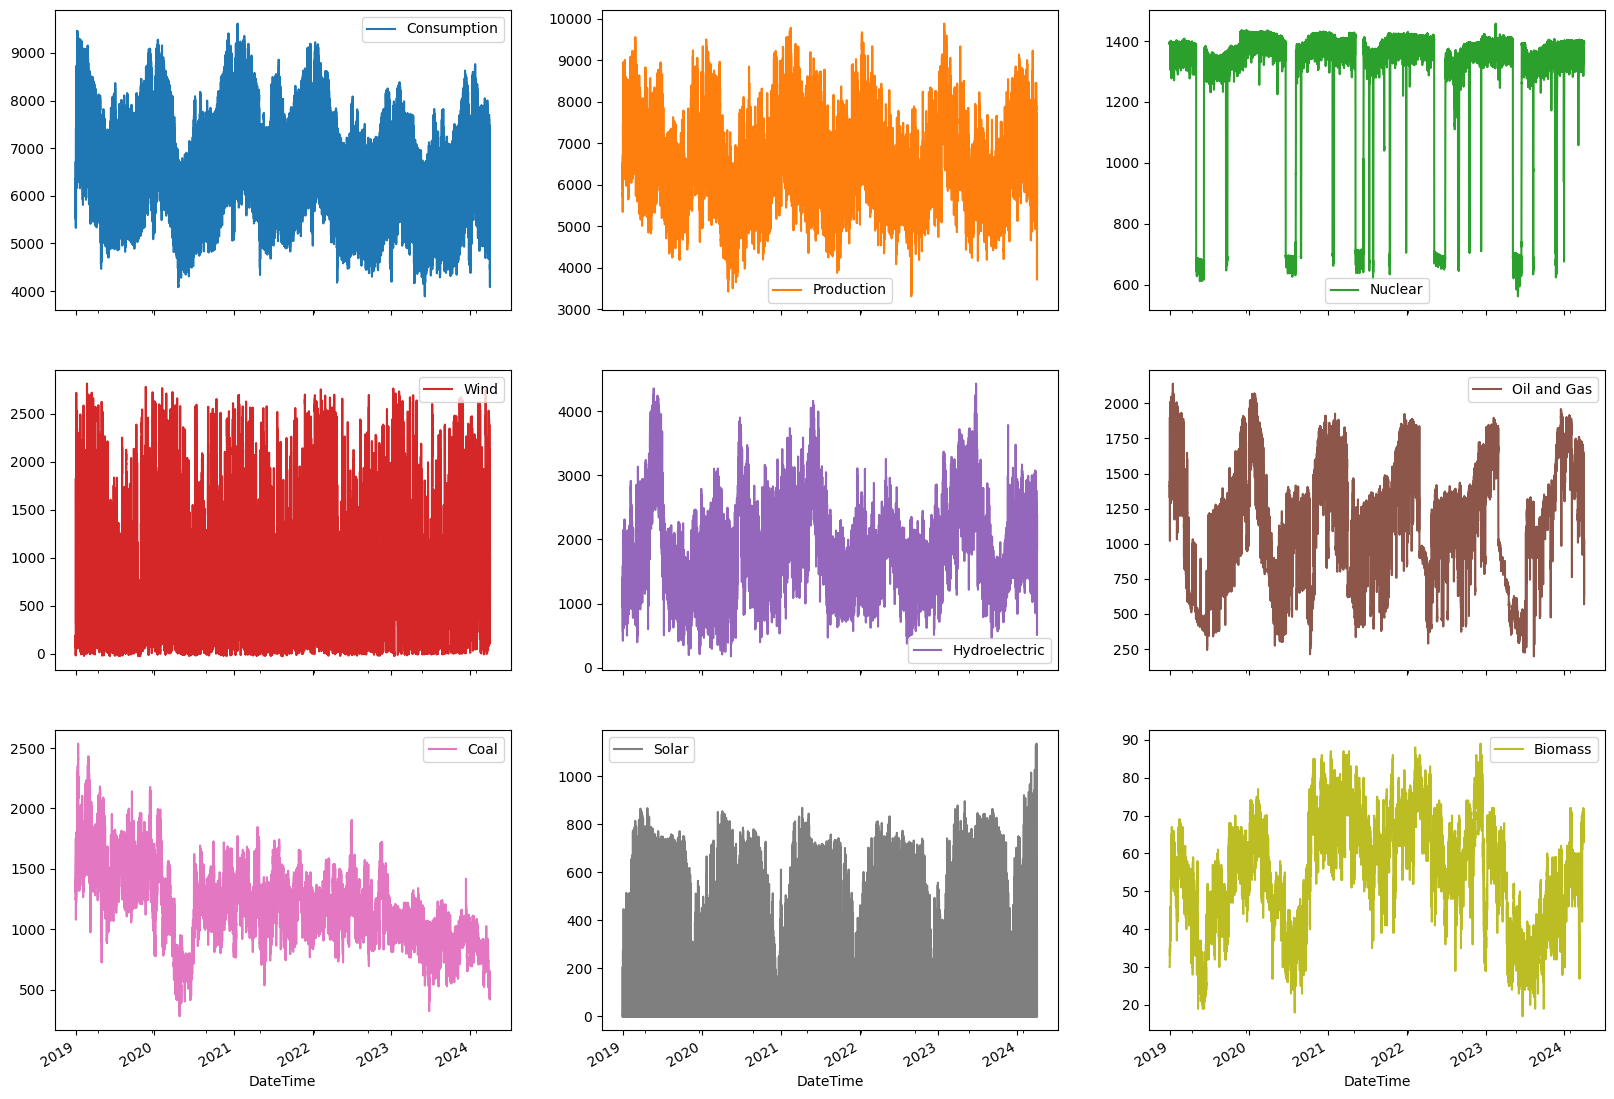

In [73]:
df2 = df.copy('Deep')
df2 = df2.set_index('DateTime')

df2.plot(subplots=True,
         layout=(3,3),
         figsize=(20,15),
         )
plt.show()

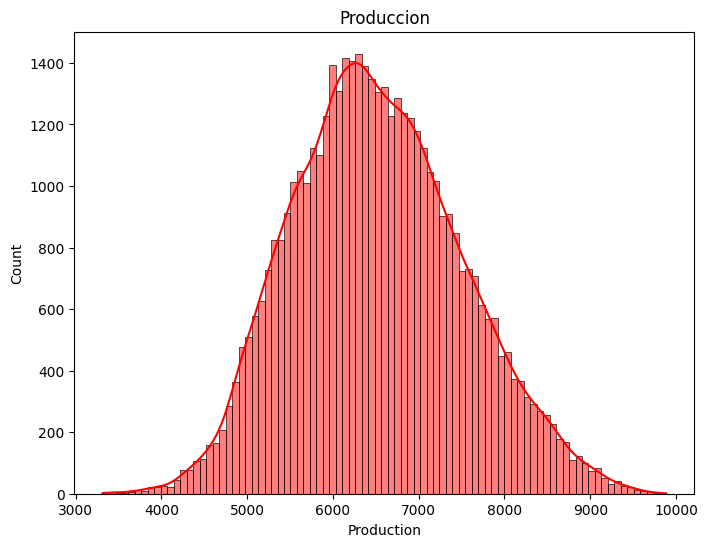

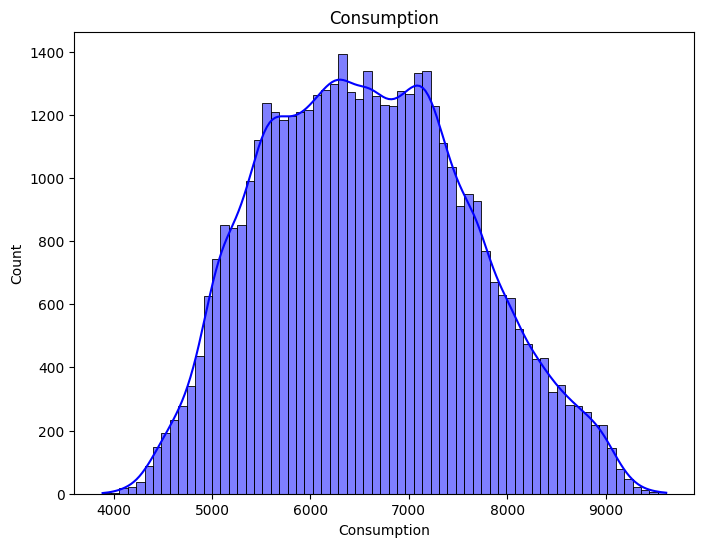

In [74]:
plt.figure(figsize=(8,6))
sns.histplot(data=df2,x='Production',kde=True,color='red')
plt.title('Produccion')
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(data=df2,x='Consumption',kde=True,color='blue')
plt.title('Consumption')
plt.show()

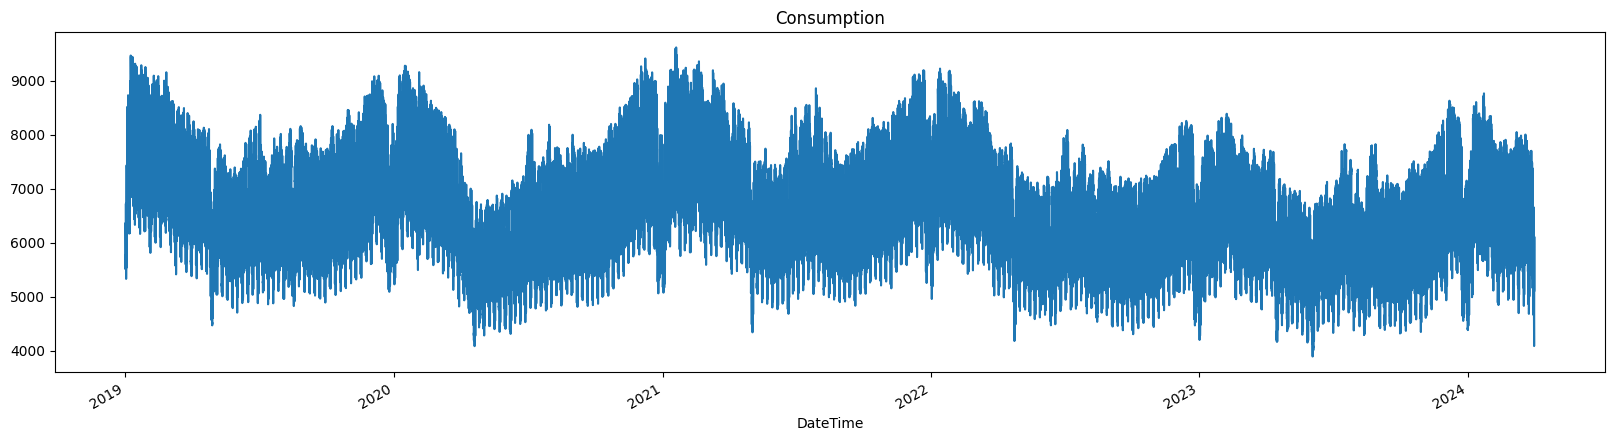

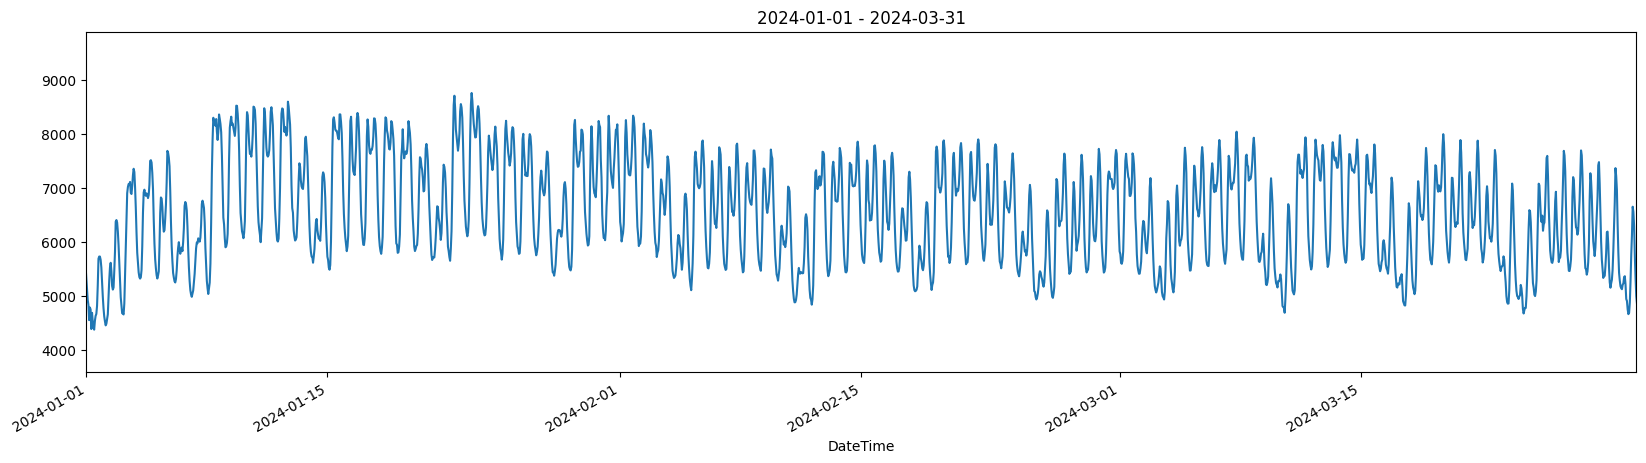

In [75]:
df_consumption = df[['DateTime','Consumption']]
df_consumption.head()

df5 = df_consumption.copy('Deep')
df5 = df5.set_index('DateTime')
df5['Consumption'].plot(figsize=(20,5))
plt.title('Consumption')
plt.show()

df5['Consumption'].plot(xlim=['2024-01-01','2024-03-31'],figsize=(20,5))
plt.title('2024-01-01 - 2024-03-31')
plt.show()

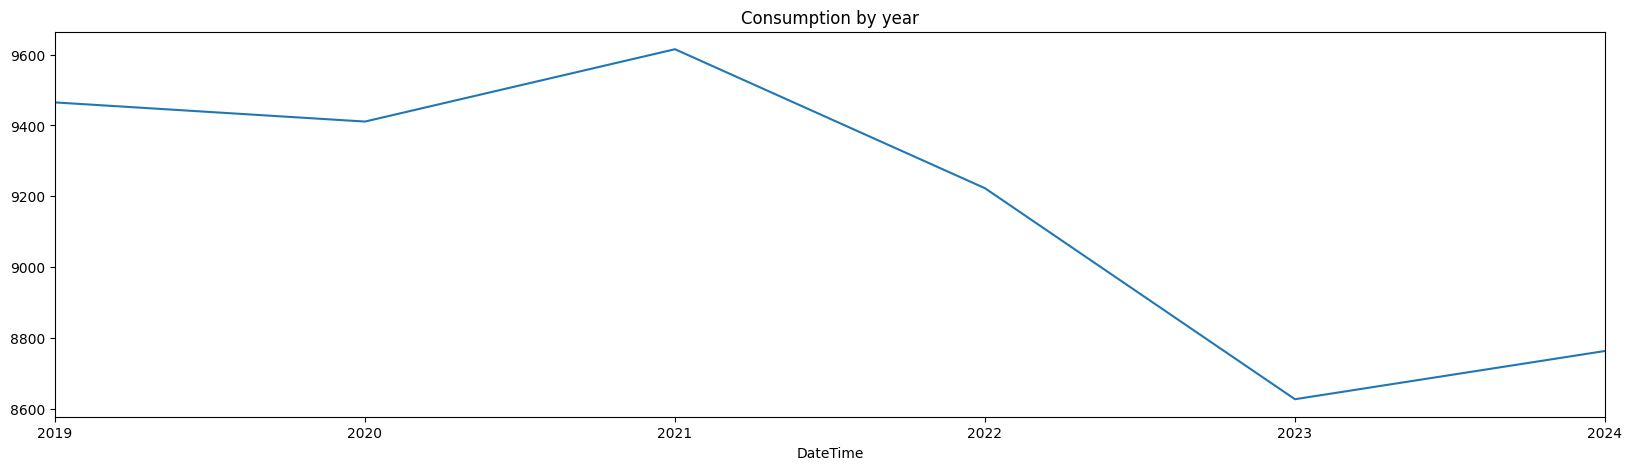

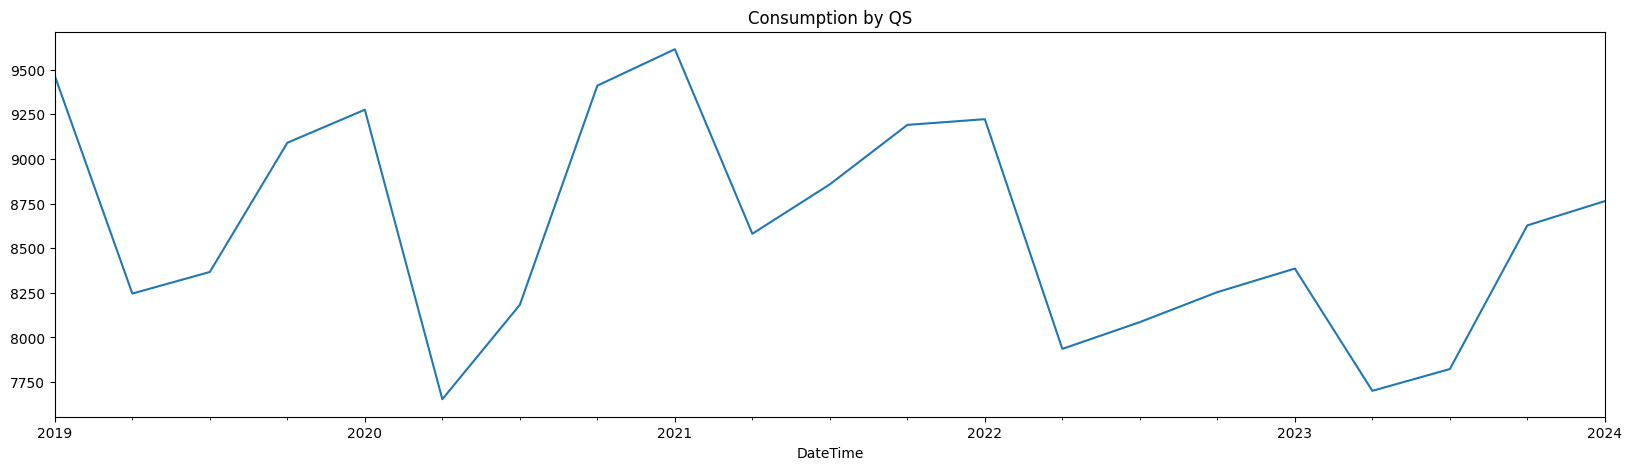

In [76]:
# Frecuenci Anual
df5.resample(rule='A').max()['Consumption'].plot(figsize=(20,5))
plt.title('Consumption by year')
plt.show()
# Frecuencia QS
df5.resample(rule='QS').max()['Consumption'].plot(figsize=(20,5));
plt.title('Consumption by QS')
plt.show()

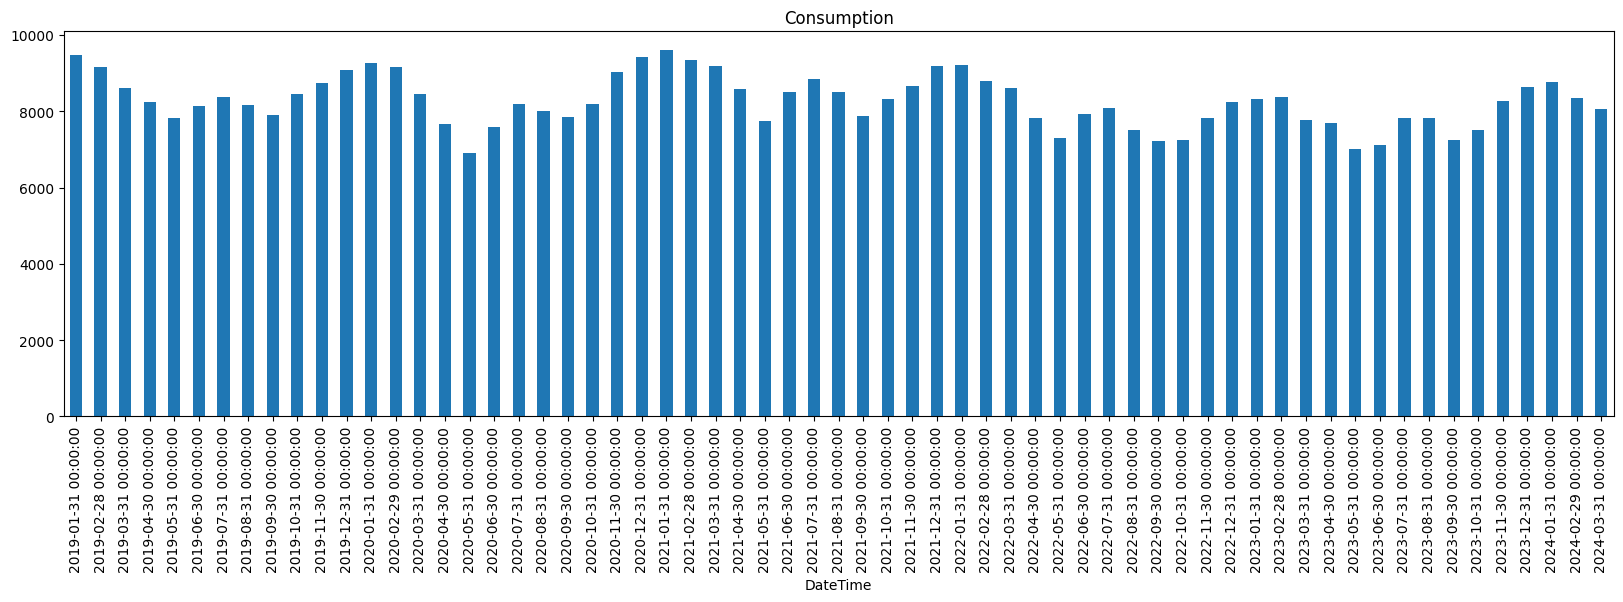

In [77]:
df5['Consumption'].resample(rule='M').max().plot(kind='bar',figsize=(20,5))
plt.title('Consumption')
plt.show()

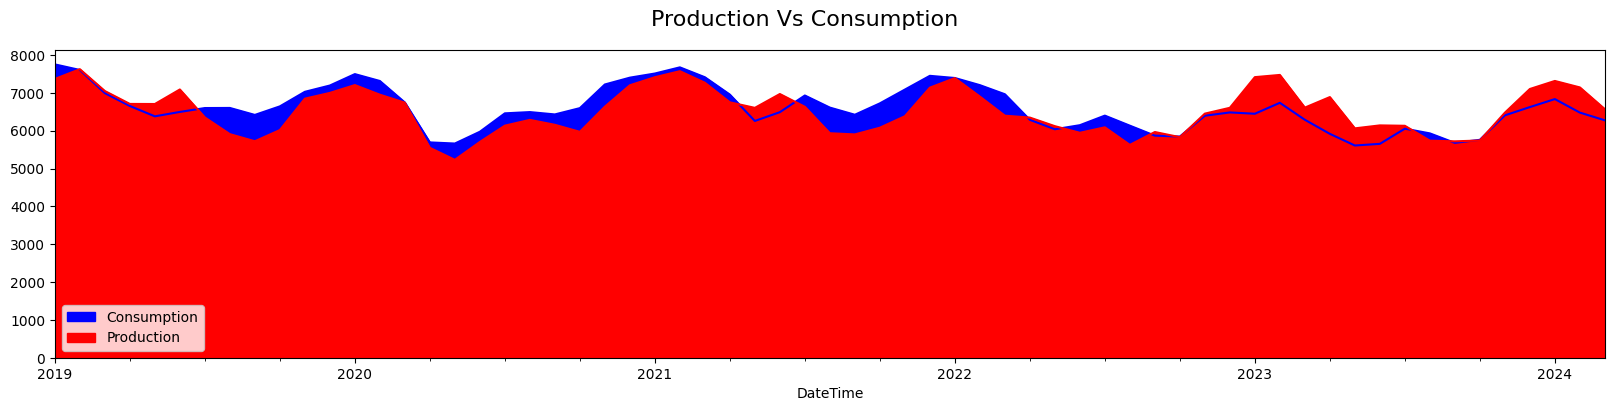

In [78]:
fig, ax = plt.subplots(figsize=(20,4)) # Create the figure and axes object
fig.suptitle('Production Vs Consumption', fontsize=16)
# Plot the first x and y axes:
df2.resample('M').mean().plot.area(use_index=True, y = 'Consumption', ax = ax,color='Blue') 
df2.resample('M').mean().plot.area(use_index=True, y = 'Production', ax = ax, secondary_y = False,color='Red')
plt.show()

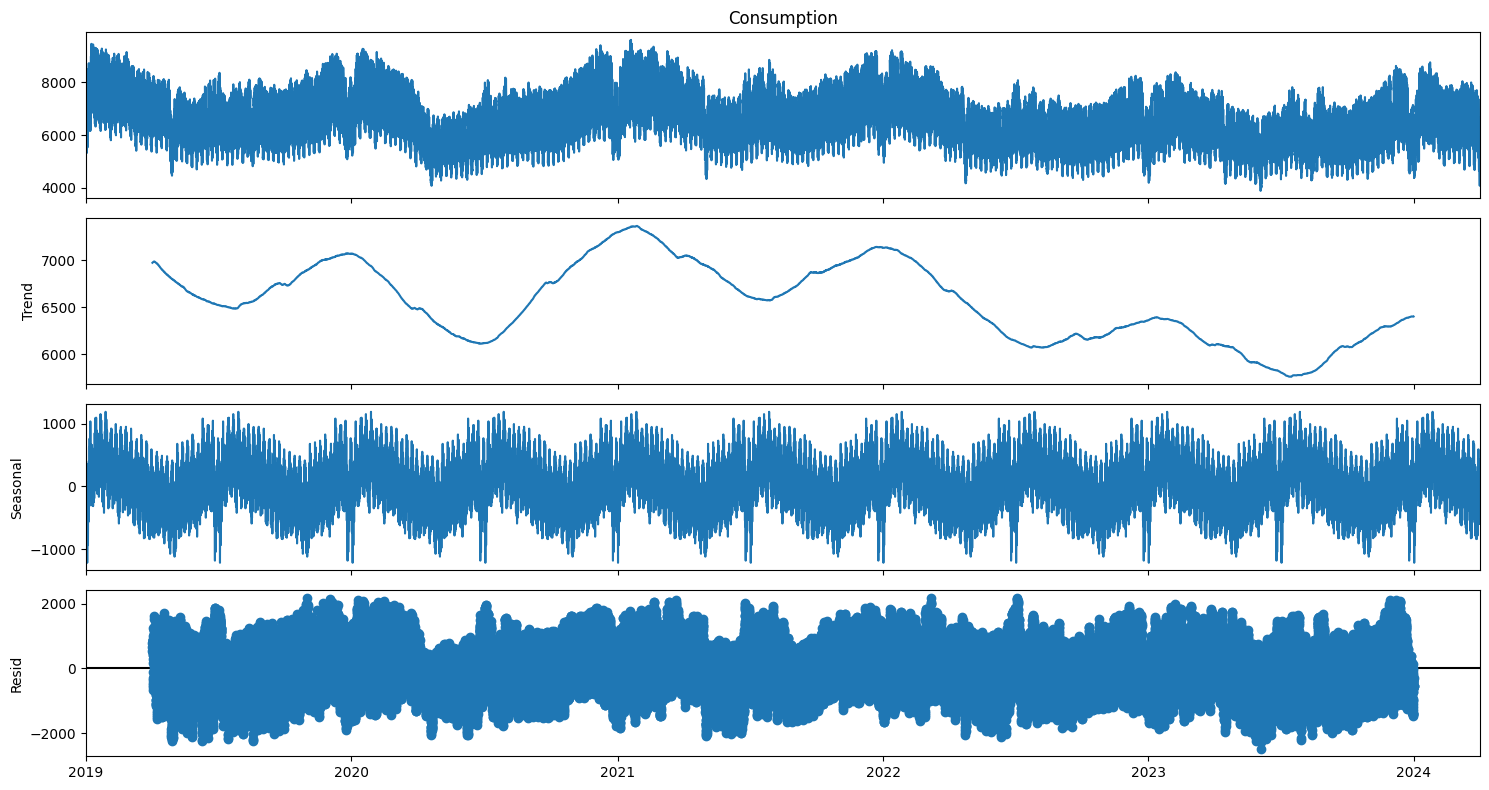

In [79]:
plt.rcParams["figure.figsize"] = (15,8)
decomp=seasonal_decompose(df2['Consumption'], model='additive', period=4380)
decomp.plot()
plt.show()

In [80]:
df_con = df.copy('deep')
df_con["DATE"] = pd.to_datetime(df_con["DateTime"]).dt.date
df_con["TIME"] = pd.to_datetime(df_con["DateTime"]).dt.time
df_con = df_con.set_index('DateTime')
df_con = df_con[["Consumption", "Production", "Solar","DATE" , "TIME"]]["2024-03-01 00:00:00" : "2024-03-30 23:59:59"]
df_con.head()

,Consumption,Production,Solar,DATE,TIME
DateTime,,,,,
2024-03-01 00:00:00,5830,6014,0,2024-03-01,00:00:00
2024-03-01 01:00:00,5780,6186,0,2024-03-01,01:00:00
2024-03-01 02:00:00,5617,6127,0,2024-03-01,02:00:00
2024-03-01 03:00:00,5600,6234,0,2024-03-01,03:00:00
2024-03-01 04:00:00,5656,6112,0,2024-03-01,04:00:00


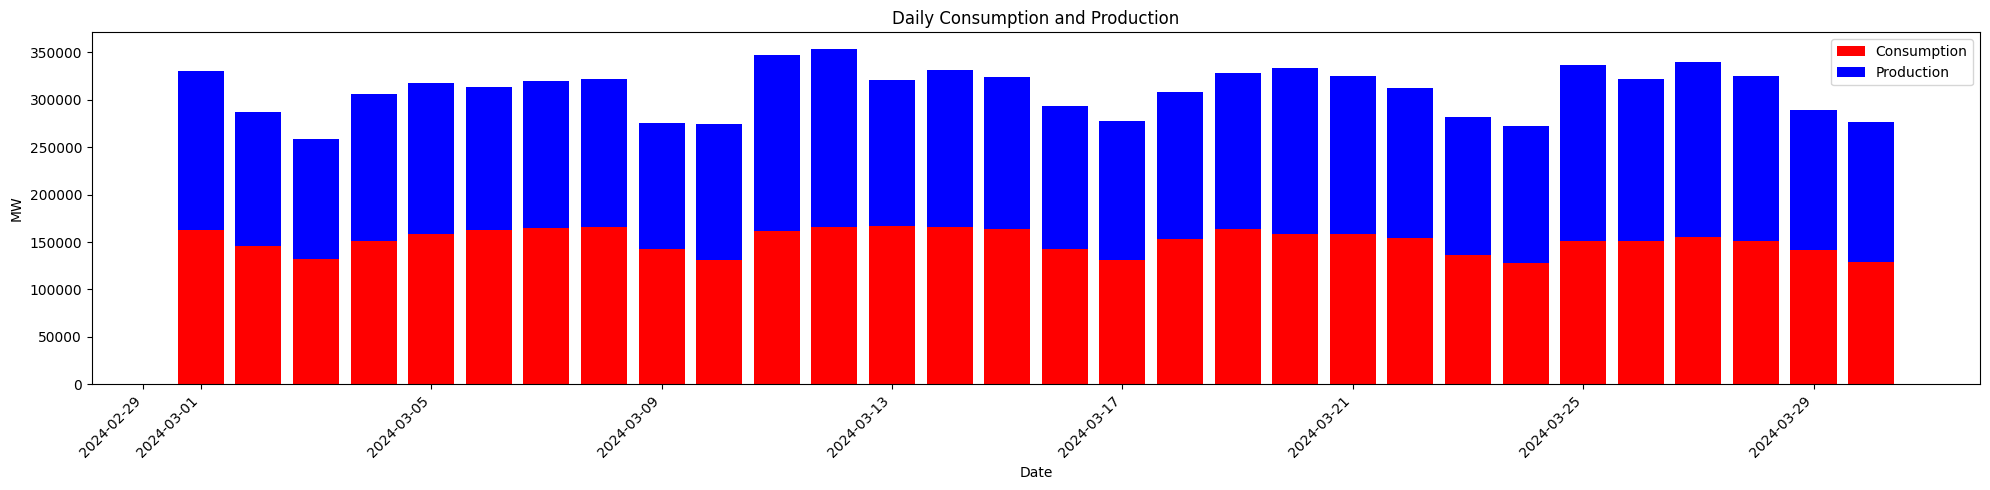

In [81]:
# Calculate daily consumption and production sums
daily_consumption = df_con.groupby('DATE')['Consumption'].agg('sum')
daily_production = df_con.groupby('DATE')['Production'].agg('sum')

# Create the combined plot
fig, ax = plt.subplots(figsize=(20, 5))  # Create figure and axis

# Plot consumption (red) and production (blue) on the same axis
ax.bar(daily_consumption.index, daily_consumption, color='red', label='Consumption')
ax.bar(daily_production.index, daily_production, color='blue', label='Production', bottom=daily_consumption.values)  # Stack on top of consumption

# Set labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('MW')
plt.title('Daily Consumption and Production')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability (optional)
plt.legend()
plt.grid(False)  # Add grid lines for better readability (optional)
plt.tight_layout()  # Adjust spacing to prevent overlapping elements (optional)
plt.show()

## **Modelo Predictivo**

In [82]:
df_new=df[['DateTime','Consumption']]
df_new.head()

,DateTime,Consumption
0,2019-01-01 00:00:00,6352
1,2019-01-01 01:00:00,6116
2,2019-01-01 02:00:00,5873
3,2019-01-01 03:00:00,5682
4,2019-01-01 04:00:00,5557


In [83]:
df_new['hour']=df_new['DateTime'].dt.hour
df_new['dayofweek'] = df_new['DateTime'].dt.dayofweek
df_new['quarter'] = df_new['DateTime'].dt.quarter
df_new['month'] = df_new['DateTime'].dt.month
df_new['year'] = df_new['DateTime'].dt.year
df_new['dayofyear'] = df_new['DateTime'].dt.dayofyear
df_new['dayofmonth'] = df_new['DateTime'].dt.day
df_new['weekofyear'] = df_new['DateTime'].apply(lambda x : x.weekofyear)
df_new = df_new.set_index('DateTime')
df_new.head()

,Consumption,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1,1,1
2019-01-01 01:00:00,6116,1,1,1,1,2019,1,1,1
2019-01-01 02:00:00,5873,2,1,1,1,2019,1,1,1
2019-01-01 03:00:00,5682,3,1,1,1,2019,1,1,1
2019-01-01 04:00:00,5557,4,1,1,1,2019,1,1,1


In [84]:
X = df_new[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
y=df_new['Consumption']

In [85]:
# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [86]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

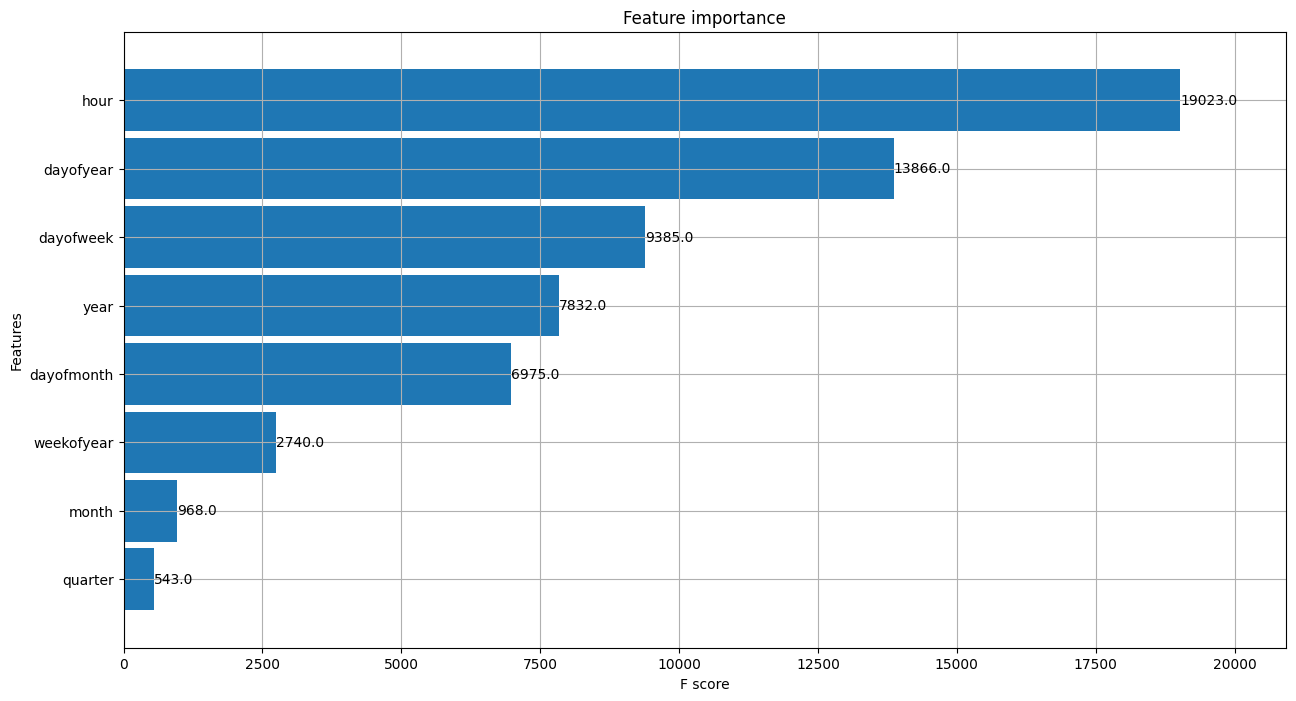

In [87]:
xgb.plot_importance(reg, height=0.9)

In [88]:
X_test_pred = reg.predict(X_test)

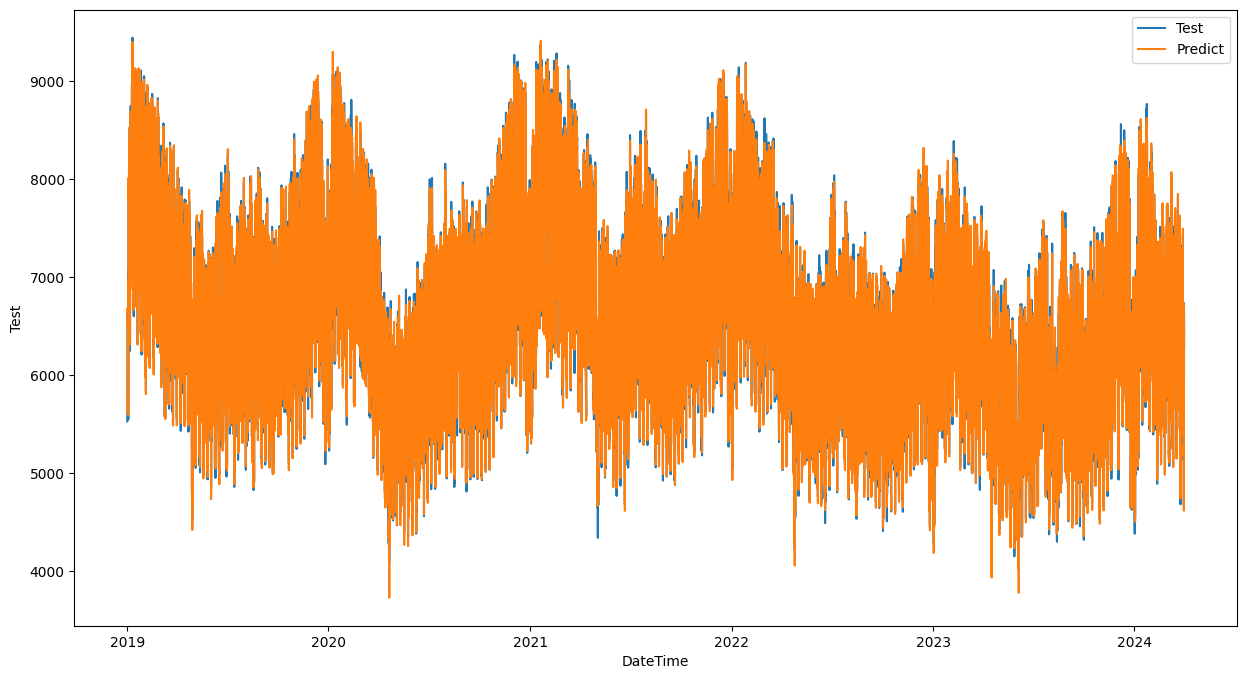

In [89]:
df_predict=X_test.copy()
df_predict['Test']=y_test
df_predict['Predict']=X_test_pred
sns.lineplot(data=df_predict,x=df_predict.index,y='Test',label='Test')
sns.lineplot(data=df_predict,x=df_predict.index,y='Predict',label='Predict')
plt.legend()
plt.show()

1. Depende de la escala de la variable objetivo

* Si la variable objetivo tiene valores grandes: Por ejemplo, si estás prediciendo ingresos anuales en miles de dólares (como $50,000), un MAE de 14 sería excelente porque representa un error relativo muy pequeño.

* Si la variable objetivo tiene valores pequeños: Por ejemplo, si predices valores en un rango de 0 a 100, un MAE de 14 podría ser bastante alto, ya que equivale a un 14% de error en promedio.

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Supongamos que tienes y_test y X_test_pred
mae = mean_absolute_error(y_test, X_test_pred)
mse = mean_squared_error(y_test, X_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, X_test_pred)
mape = np.mean(np.abs((y_test - X_test_pred) / y_test)) * 100

# Imprimir las métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}%")


MAE: 67.40704861016788
MSE: 8714.774131139699
RMSE: 93.35295459244821
R²: 0.9919951558113098
MAPE: 1.0357265302598275%


## **Hiperparametros XGB**

In [91]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define el modelo base
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Define la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [100, 500, 1000],         # Número de árboles
    'max_depth': [3, 5, 7],                  # Profundidad máxima
    'learning_rate': [0.01, 0.1, 0.2],       # Tasa de aprendizaje
    'subsample': [0.8, 1.0],                 # Fracción de datos por árbol
    'colsample_bytree': [0.8, 1.0],          # Fracción de características por árbol
    'gamma': [0, 1, 5],                      # Regularización
}

# Configurar el GridSearch
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=3,              # Validación cruzada de 3 particiones
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           verbose=1,
                           n_jobs=-1)         # Usa todos los núcleos disponibles

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Imprime los mejores parámetros y puntajes
print("Best parameters:", grid_search.best_params_)
print("Best score (neg MSE):", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 1.0}
Best score (neg MSE): -11316.03561932603


In [92]:
X_test_pred = grid_search.predict(X_test)

In [93]:
# Supongamos que tienes y_test y X_test_pred
mae = mean_absolute_error(y_test, X_test_pred)
mse = mean_squared_error(y_test, X_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, X_test_pred)
mape = np.mean(np.abs((y_test - X_test_pred) / y_test)) * 100

# Imprimir las métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}%")

MAE: 61.899116467201594
MSE: 7429.153039905334
RMSE: 86.19253471099069
R²: 0.9931760430335999
MAPE: 0.9494433519614534%


## **LGBMRegressor**

In [94]:
import lightgbm as lgb

In [95]:
# Inicializar el modelo con parámetros clave
model_lgr = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    boosting_type='gbdt',
    random_state=42,
    num_leaves=100,
    subsample=0.6,
    max_depth=25,
    colsample_bytree=0.8,
    reg_alpha=0.01, 
    reg_lambda=0.01,
    subsample_freq=3
)

# Entrenar el modelo usando `early_stopping`
model_lgr.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluar en conjunto de entrenamiento y prueba
    eval_metric="mean_absolute_error",  # Métrica de evaluación
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True)  # Early stopping como callback
    ]
)

# Información del mejor número de árboles
print(f"Mejor iteración: {model_lgr.best_iteration_}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 36808, number of used features: 8
[LightGBM] [Info] Start training from score 6583.061101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3819]	training's l1: 30.8953	training's l2: 1680.02	valid_1's l1: 62.8386	valid_1's l2: 7496.73
Mejor iteración: 3819


In [96]:
X_test_pred = model_lgr.predict(X_test)

In [97]:
# Supongamos que tienes y_test y X_test_pred
mae = mean_absolute_error(y_test, X_test_pred)
mse = mean_squared_error(y_test, X_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, X_test_pred)
mape = np.mean(np.abs((y_test - X_test_pred) / y_test)) * 100

# Imprimir las métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}%")

MAE: 62.83864932899775
MSE: 7496.72887599613
RMSE: 86.5836524754883
R²: 0.9931139794532295
MAPE: 0.9652468201830321%


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

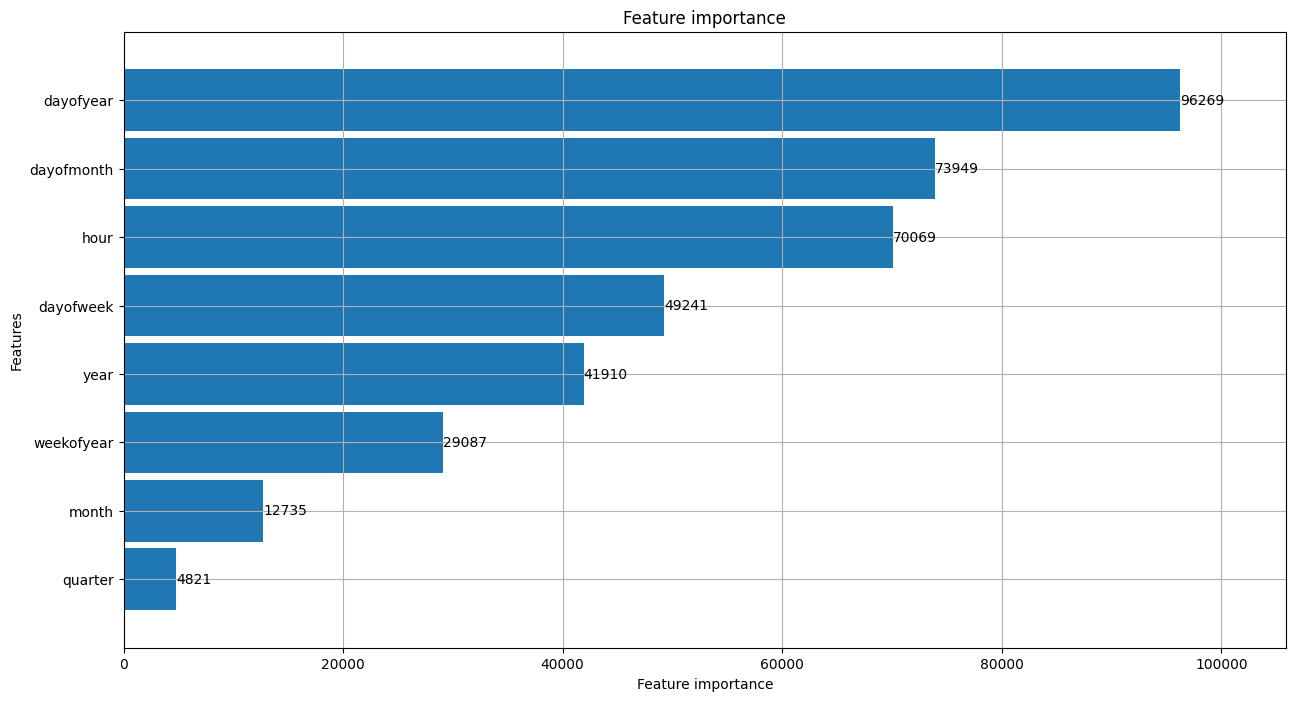

In [98]:
lgb.plot_importance(model_lgr,height=0.9)